# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


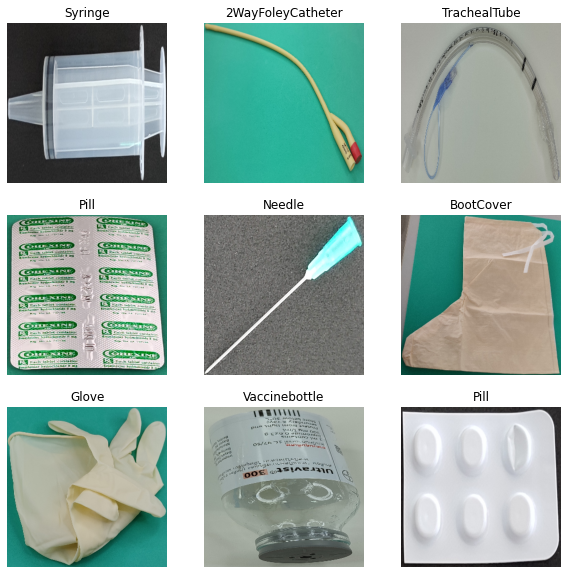

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                21033     
Total params: 22,872,905
Trainable params: 1,070,121
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

4


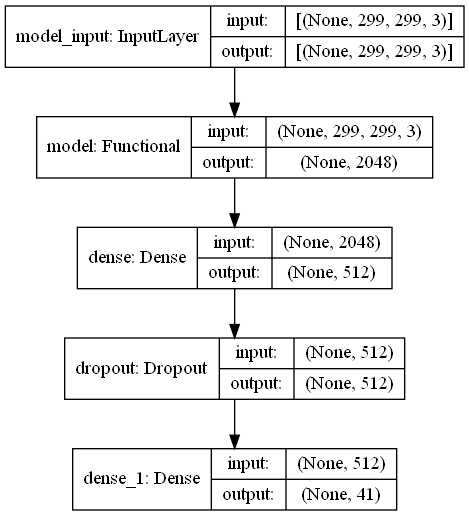

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense512-NoClassImbalanced-NoAug-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 42s 320ms/step - loss: 1.3553 - accuracy: 0.6436 - val_loss: 0.5206 - val_accuracy: 0.8473
Epoch 2/2000
49/49 [==============================] - 9s 176ms/step - loss: 0.3802 - accuracy: 0.8856 - val_loss: 0.2852 - val_accuracy: 0.9159
Epoch 3/2000
49/49 [==============================] - 9s 175ms/step - loss: 0.1946 - accuracy: 0.9509 - val_loss: 0.2368 - val_accuracy: 0.9327
Epoch 4/2000
49/49 [==============================] - 9s 176ms/step - loss: 0.1249 - accuracy: 0.9703 - val_loss: 0.2029 - val_accuracy: 0.9431
Epoch 5/2000
49/49 [==============================] - 9s 185ms/step - loss: 0.0991 - accuracy: 0.9712 - val_loss: 0.2151 - val_accuracy: 0.9327
Epoch 6/2000
49/49 [==============================] - 9s 188ms/step - loss: 0.0694 - accuracy: 0.9851 - val_loss: 0.1581 - val_accuracy: 0.9560
Epoch 7/2000
49/49 [==============================] - 9s 185ms/step - loss: 0.0536 - accuracy: 0.9906 - val_loss: 0.1413 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

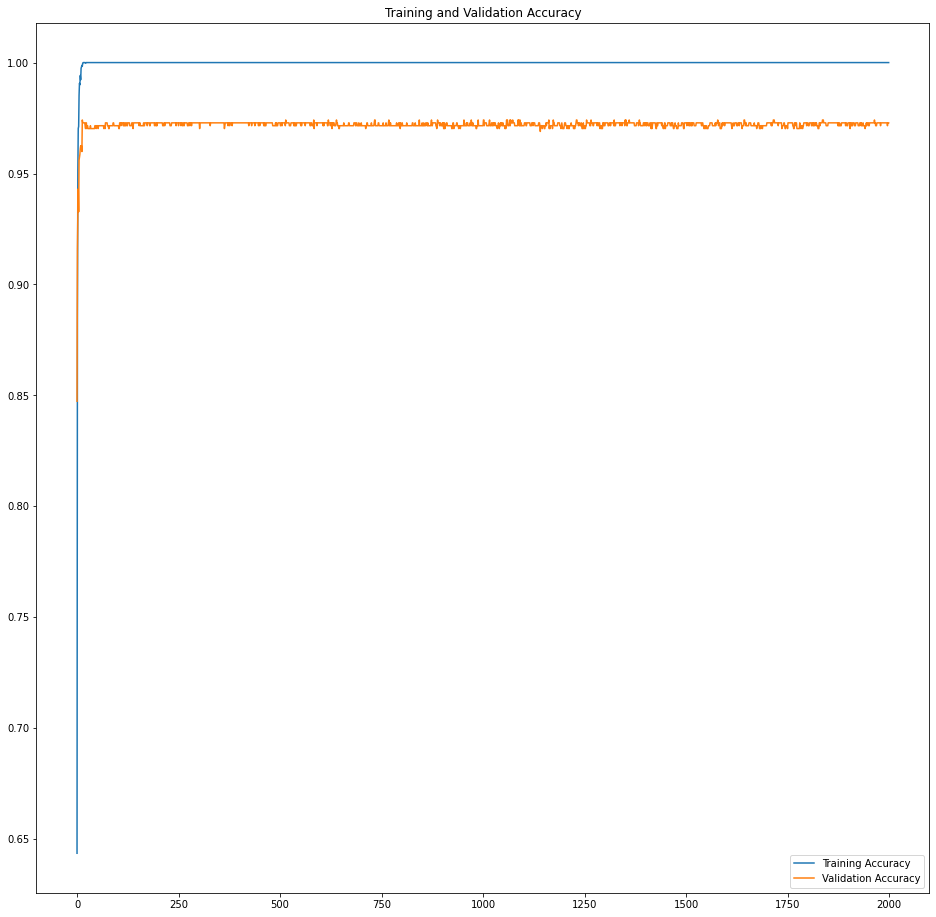

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


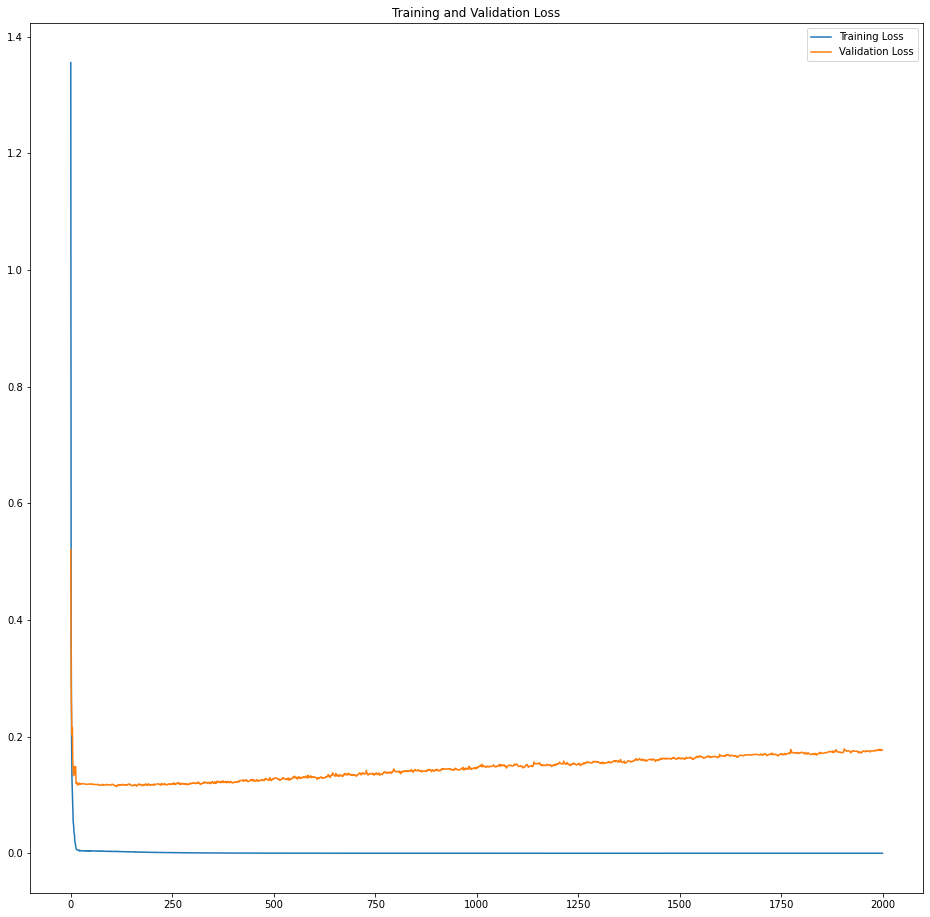

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 351ms/step - loss: 0.8531 - accuracy: 0.8428
test_indoor_ds_results:test loss, test acc: [0.8531107902526855, 0.8428093791007996]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 25s 417ms/step - loss: 2.2246 - accuracy: 0.7414
test_outdoor_ds_results:test loss, test acc: [2.2246274948120117, 0.7414012551307678]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 201ms/step - loss: 2.3807 - accuracy: 0.7103
test_belt_ds_results:test loss, test acc: [2.3806707859039307, 0.7103354334831238]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_LowDeepDense512-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteChe

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 141ms/step - loss: 1.4008 - accuracy: 0.6854
Epoch040 
 test_indoor_acc=0.8277592062950134 
 test_outdoor_acc=0.7439490556716919 
 test_belt_acc=0.6854034662246704
35/35 [==============================] - 5s 141ms/step - loss: 1.4095 - accuracy: 0.6895
Epoch080 
 test_indoor_acc=0.8311036825180054 
 test_outdoor_acc=0.743630588054657 
 test_belt_acc=0.6894832253456116
35/35 [==============================] - 5s 138ms/step - loss: 1.4107 - accuracy: 0.6917
Epoch120 
 test_indoor_acc=0.8322185277938843 
 test_outdoor_acc=0.7458598613739014 
 test_belt_acc=0.6917497515678406
35/35 [==============================] - 5s 141ms/step - loss: 1.4305 - accuracy: 0.6976
Epoch160 
 test_indoor_acc=0.8338907361030579 
 test_outdoor_acc=0.7429936528205872 
 test_belt_acc=0.6976428031921387
35/35 [==============================] - 5s 140ms/step - loss: 1.4742 - accuracy: 0.6963
Epoch200 
 test_indoor_acc=0.8355630040168762 
 test_outdoor_acc=0.7426751852035

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

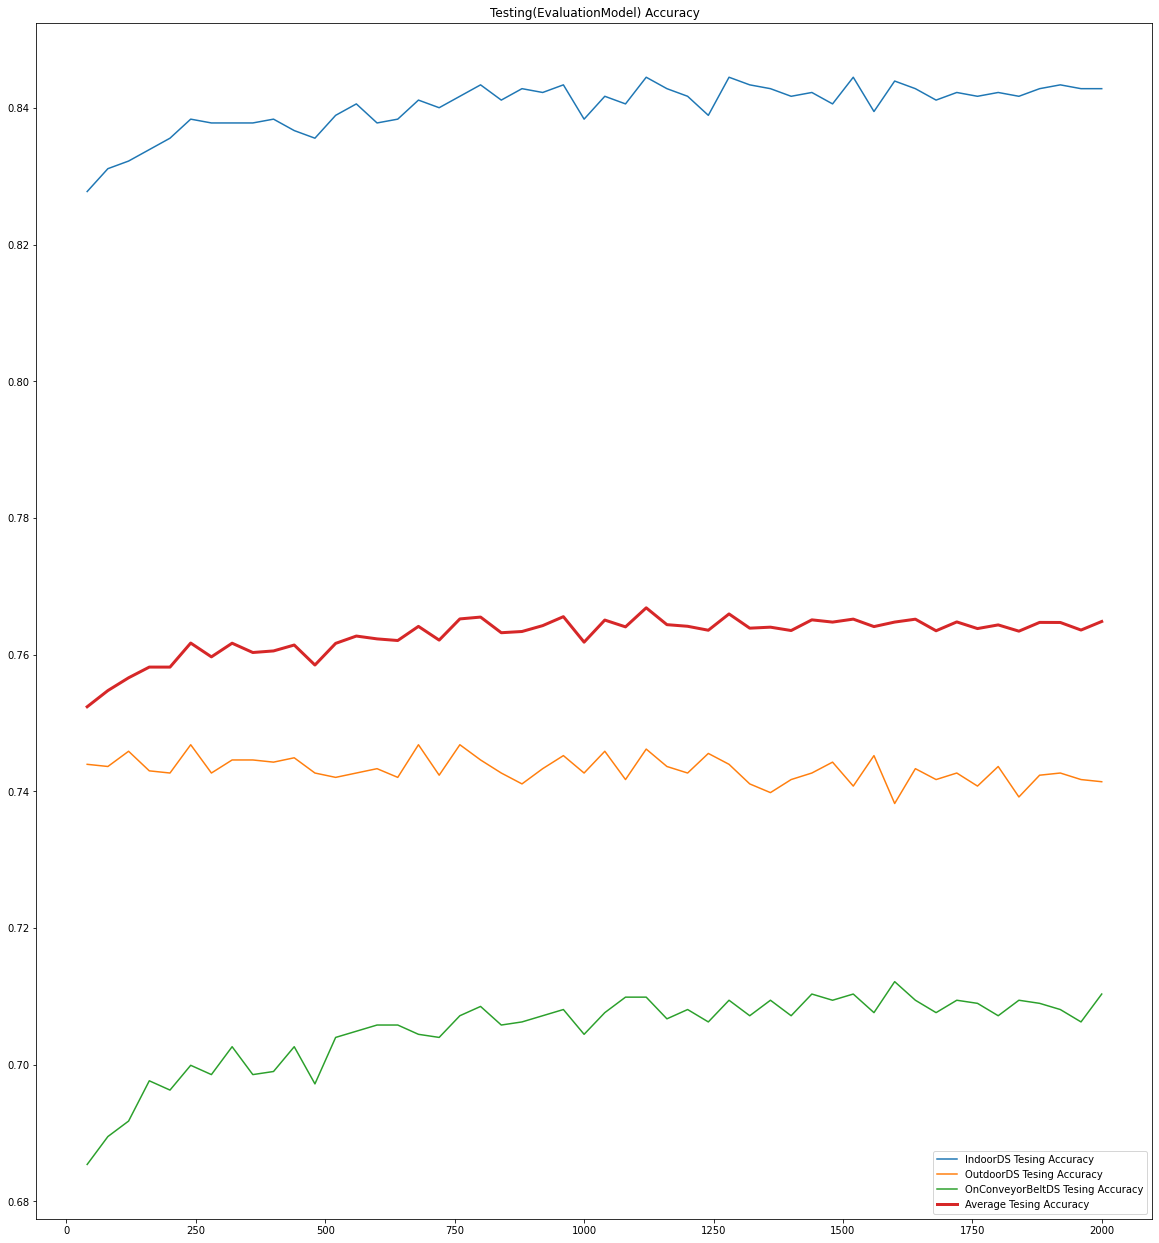

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7668473521868387
max index -> 27
The [Epoch] of max acc -> 1120


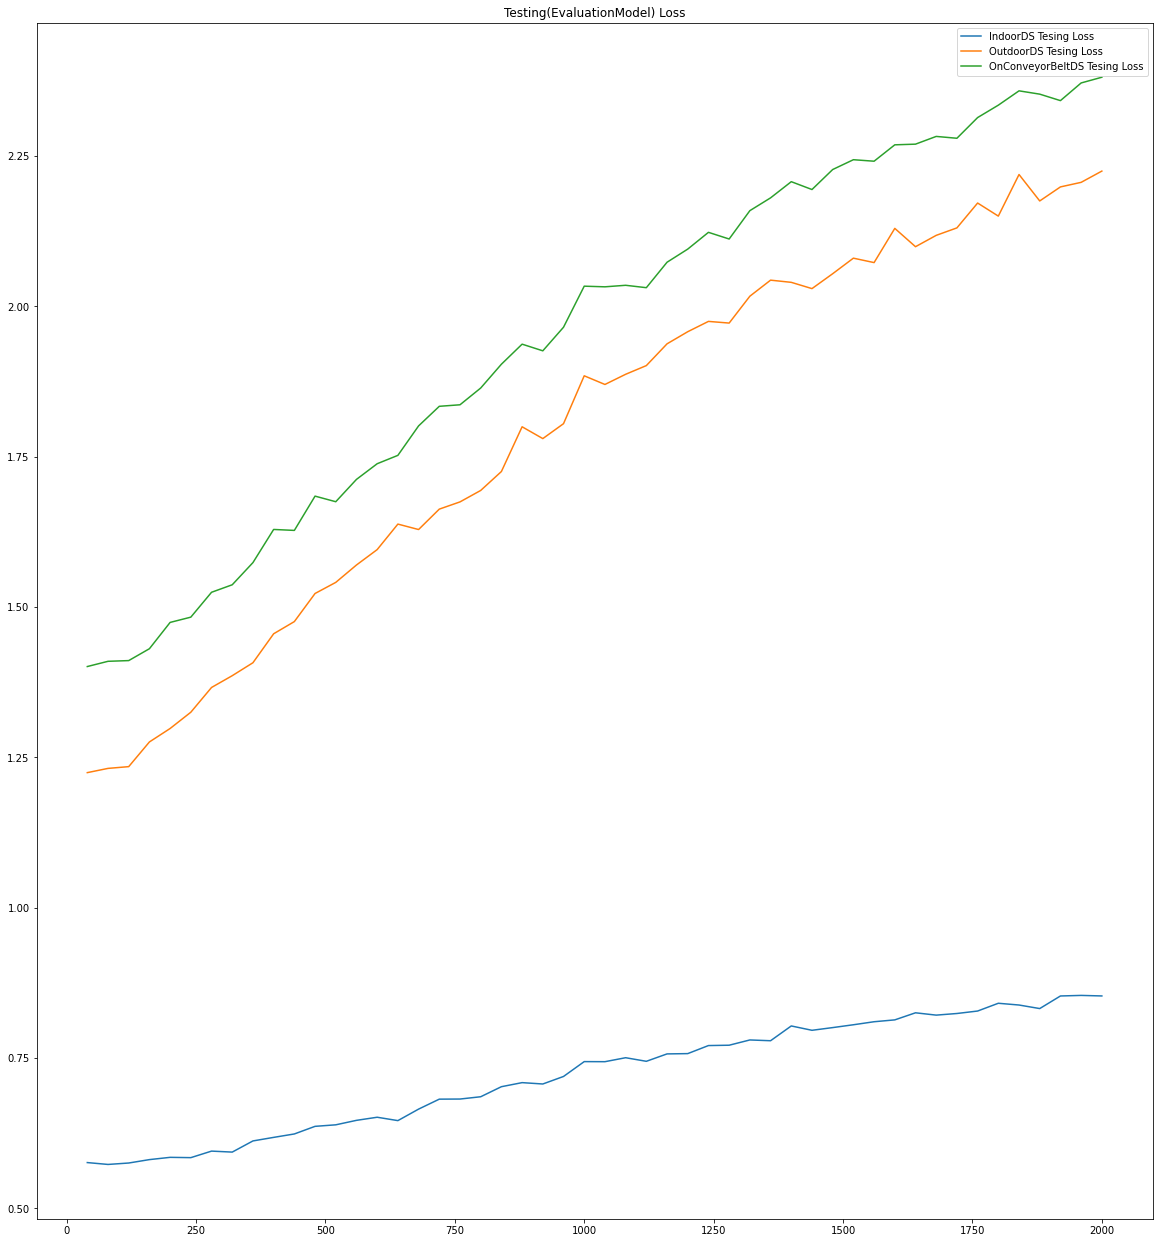

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8277592062950134,
 0.8311036825180054,
 0.8322185277938843,
 0.8338907361030579,
 0.8355630040168762,
 0.8383500576019287,
 0.8377926349639893,
 0.8377926349639893,
 0.8377926349639893,
 0.8383500576019287,
 0.8366777896881104,
 0.8355630040168762,
 0.8389074802398682,
 0.8405796885490417,
 0.8377926349639893,
 0.8383500576019287,
 0.8411371111869812,
 0.8400223255157471,
 0.8416945338249207,
 0.843366801738739,
 0.8411371111869812,
 0.8428093791007996,
 0.8422519564628601,
 0.843366801738739,
 0.8383500576019287,
 0.8416945338249207,
 0.8405796885490417,
 0.8444815874099731,
 0.8428093791007996,
 0.8416945338249207,
 0.8389074802398682,
 0.8444815874099731,
 0.843366801738739,
 0.8428093791007996,
 0.8416945338249207,
 0.8422519564628601,
 0.8405796885490417,
 0.8444815874099731,
 0.8394649028778076,
 0.8439241647720337,
 0.8428093791007996,
 0.8411371111869812,
 0.8422519564628601,
 0.8416945338249207,
 0.8422519564628601,
 0.8416945338249207,
 0.8428093791007996,
 0.8433668017387

In [38]:
test_outdoor_acc

[0.7439490556716919,
 0.743630588054657,
 0.7458598613739014,
 0.7429936528205872,
 0.7426751852035522,
 0.7468152642250061,
 0.7426751852035522,
 0.7445859909057617,
 0.7445859909057617,
 0.7442675232887268,
 0.7449044585227966,
 0.7426751852035522,
 0.7420381903648376,
 0.7426751852035522,
 0.7433121204376221,
 0.7420381903648376,
 0.7468152642250061,
 0.7423567175865173,
 0.7468152642250061,
 0.7445859909057617,
 0.7426751852035522,
 0.7410827875137329,
 0.7433121204376221,
 0.7452229261398315,
 0.7426751852035522,
 0.7458598613739014,
 0.7417197227478027,
 0.7461783289909363,
 0.743630588054657,
 0.7426751852035522,
 0.7455413937568665,
 0.7439490556716919,
 0.7410827875137329,
 0.7398089170455933,
 0.7417197227478027,
 0.7426751852035522,
 0.7442675232887268,
 0.740764319896698,
 0.7452229261398315,
 0.7382165789604187,
 0.7433121204376221,
 0.7417197227478027,
 0.7426751852035522,
 0.740764319896698,
 0.743630588054657,
 0.7391719818115234,
 0.7423567175865173,
 0.742675185203552

In [39]:
test_belt_acc

[0.6854034662246704,
 0.6894832253456116,
 0.6917497515678406,
 0.6976428031921387,
 0.6962828636169434,
 0.6999093294143677,
 0.6985493898391724,
 0.7026292085647583,
 0.6985493898391724,
 0.699002742767334,
 0.7026292085647583,
 0.6971895098686218,
 0.7039891481399536,
 0.7048957347869873,
 0.7058023810386658,
 0.7058023810386658,
 0.7044424414634705,
 0.7039891481399536,
 0.7071622610092163,
 0.7085222005844116,
 0.7058023810386658,
 0.7062556743621826,
 0.7071622610092163,
 0.7080689072608948,
 0.7044424414634705,
 0.7076156139373779,
 0.7098821401596069,
 0.7098821401596069,
 0.7067089676856995,
 0.7080689072608948,
 0.7062556743621826,
 0.7094288468360901,
 0.7071622610092163,
 0.7094288468360901,
 0.7071622610092163,
 0.7103354334831238,
 0.7094288468360901,
 0.7103354334831238,
 0.7076156139373779,
 0.7121486663818359,
 0.7094288468360901,
 0.7076156139373779,
 0.7094288468360901,
 0.7089754939079285,
 0.7071622610092163,
 0.7094288468360901,
 0.7089754939079285,
 0.70806890726

In [40]:
test_indoor_loss

[0.5760501027107239,
 0.5729514360427856,
 0.5753191113471985,
 0.5809807777404785,
 0.5847491025924683,
 0.5842517018318176,
 0.5951124429702759,
 0.5934768915176392,
 0.6120346188545227,
 0.6179409027099609,
 0.6236311197280884,
 0.6362947821617126,
 0.638823926448822,
 0.6462631821632385,
 0.6514306664466858,
 0.6458222270011902,
 0.664943516254425,
 0.6815061569213867,
 0.6816934943199158,
 0.6855021715164185,
 0.7022184133529663,
 0.7089676260948181,
 0.7067151665687561,
 0.7192274332046509,
 0.7439336776733398,
 0.7437987923622131,
 0.7503978610038757,
 0.7444409728050232,
 0.7567412853240967,
 0.7572256922721863,
 0.7706148028373718,
 0.771186888217926,
 0.7799323201179504,
 0.7786430716514587,
 0.8032184839248657,
 0.7960001826286316,
 0.8004897236824036,
 0.8052000999450684,
 0.8102318048477173,
 0.8133125901222229,
 0.8250857591629028,
 0.8212242126464844,
 0.8239256739616394,
 0.8280293941497803,
 0.8409398198127747,
 0.8380173444747925,
 0.832129180431366,
 0.85306298732757

In [41]:
test_outdoor_loss

[1.22441565990448,
 1.2314661741256714,
 1.2343891859054565,
 1.2754452228546143,
 1.2978184223175049,
 1.3248673677444458,
 1.3660203218460083,
 1.3856205940246582,
 1.4071556329727173,
 1.4553009271621704,
 1.4755665063858032,
 1.5223076343536377,
 1.5407438278198242,
 1.5696556568145752,
 1.5952551364898682,
 1.6376737356185913,
 1.6286284923553467,
 1.6625640392303467,
 1.674572229385376,
 1.6936142444610596,
 1.72508704662323,
 1.7994754314422607,
 1.7798407077789307,
 1.8046422004699707,
 1.8842499256134033,
 1.8698313236236572,
 1.8867576122283936,
 1.9012120962142944,
 1.937401533126831,
 1.9575632810592651,
 1.9747027158737183,
 1.9719206094741821,
 2.0166003704071045,
 2.043273448944092,
 2.0396480560302734,
 2.029224157333374,
 2.0539796352386475,
 2.0798404216766357,
 2.0724825859069824,
 2.1293625831604004,
 2.098911762237549,
 2.1177661418914795,
 2.1301870346069336,
 2.1715142726898193,
 2.1497862339019775,
 2.218931198120117,
 2.1749799251556396,
 2.1983225345611572,
 2

In [42]:
test_belt_loss

[1.4008166790008545,
 1.4095263481140137,
 1.4107146263122559,
 1.4304590225219727,
 1.4741891622543335,
 1.4829567670822144,
 1.5242984294891357,
 1.5367822647094727,
 1.5736494064331055,
 1.6287637948989868,
 1.6271761655807495,
 1.684178113937378,
 1.6748721599578857,
 1.711991310119629,
 1.7380417585372925,
 1.7519530057907104,
 1.800927996635437,
 1.8335143327713013,
 1.8360559940338135,
 1.8639049530029297,
 1.9035011529922485,
 1.9368479251861572,
 1.9257879257202148,
 1.9650160074234009,
 2.0332627296447754,
 2.0321993827819824,
 2.0347416400909424,
 2.0307528972625732,
 2.0730741024017334,
 2.094916582107544,
 2.1227846145629883,
 2.111696243286133,
 2.1588339805603027,
 2.18011736869812,
 2.207010507583618,
 2.1939709186553955,
 2.2272207736968994,
 2.2435436248779297,
 2.2410526275634766,
 2.2683053016662598,
 2.269408941268921,
 2.2822701930999756,
 2.279204845428467,
 2.3136179447174072,
 2.334240198135376,
 2.35805082321167,
 2.352562189102173,
 2.341791868209839,
 2.3711

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1120-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5423
FP=1717
acc=0.7595238095238095
all check = 7140


In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 75.0%
2WayConnectorforFoley acc = 89.1156462585034%
2WayFoleyCatheter acc = 74.6268656716418%
3WayConnectorforFoley acc = 95.72649572649573%
3Waystopcock acc = 97.2972972972973%
AlcoholBottle acc = 85.625%
AlcoholPad acc = 45.23809523809524%
BootCover acc = 69.27710843373494%
CottonBall acc = 83.23353293413174%
CottonSwap acc = 77.62237762237763%
Dilator acc = 70.08547008547008%
DisposableInfusionSet acc = 54.86725663716814%
ExtensionTube acc = 34.146341463414636%
FaceShield acc = 69.1358024691358%
FrontLoadSyringe acc = 51.32743362831859%
GauzePad acc = 68.75%
Glove acc = 77.67857142857143%
GuideWire acc = 29.464285714285715%
LiquidBottle acc = 63.358778625954194%
Mask acc = 94.8051948051948%
NGTube acc = 41.935483870967744%
NasalCannula acc = 69.02654867256636%
Needle acc = 82.5%
OxygenMask acc = 96.99248120300751%
PPESuit acc = 93.54838709677419%
PharmaceuticalProduct acc = 66.1214953271028%
Pill acc = 95.65826330532214%
PillBottle acc = 67.44186046511628

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 87,   1,   0, ...,   0,   0,   0],
       [  1, 131,   0, ...,   0,   0,   0],
       [  0,   0, 100, ...,   0,   2,   4],
       ...,
       [  0,   0,   0, ...,  72,   0,   1],
       [  0,   0,   0, ...,   1, 186,   0],
       [  0,   0,   0, ...,   0,   1,  82]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[75.        ,  0.86206897,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68027211, 89.11564626,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 74.62686567, ...,  0.        ,
         1.49253731,  2.98507463],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 60.        ,
         0.        ,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        87.32394366,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.87719298, 71.92982456]])

<AxesSubplot:>

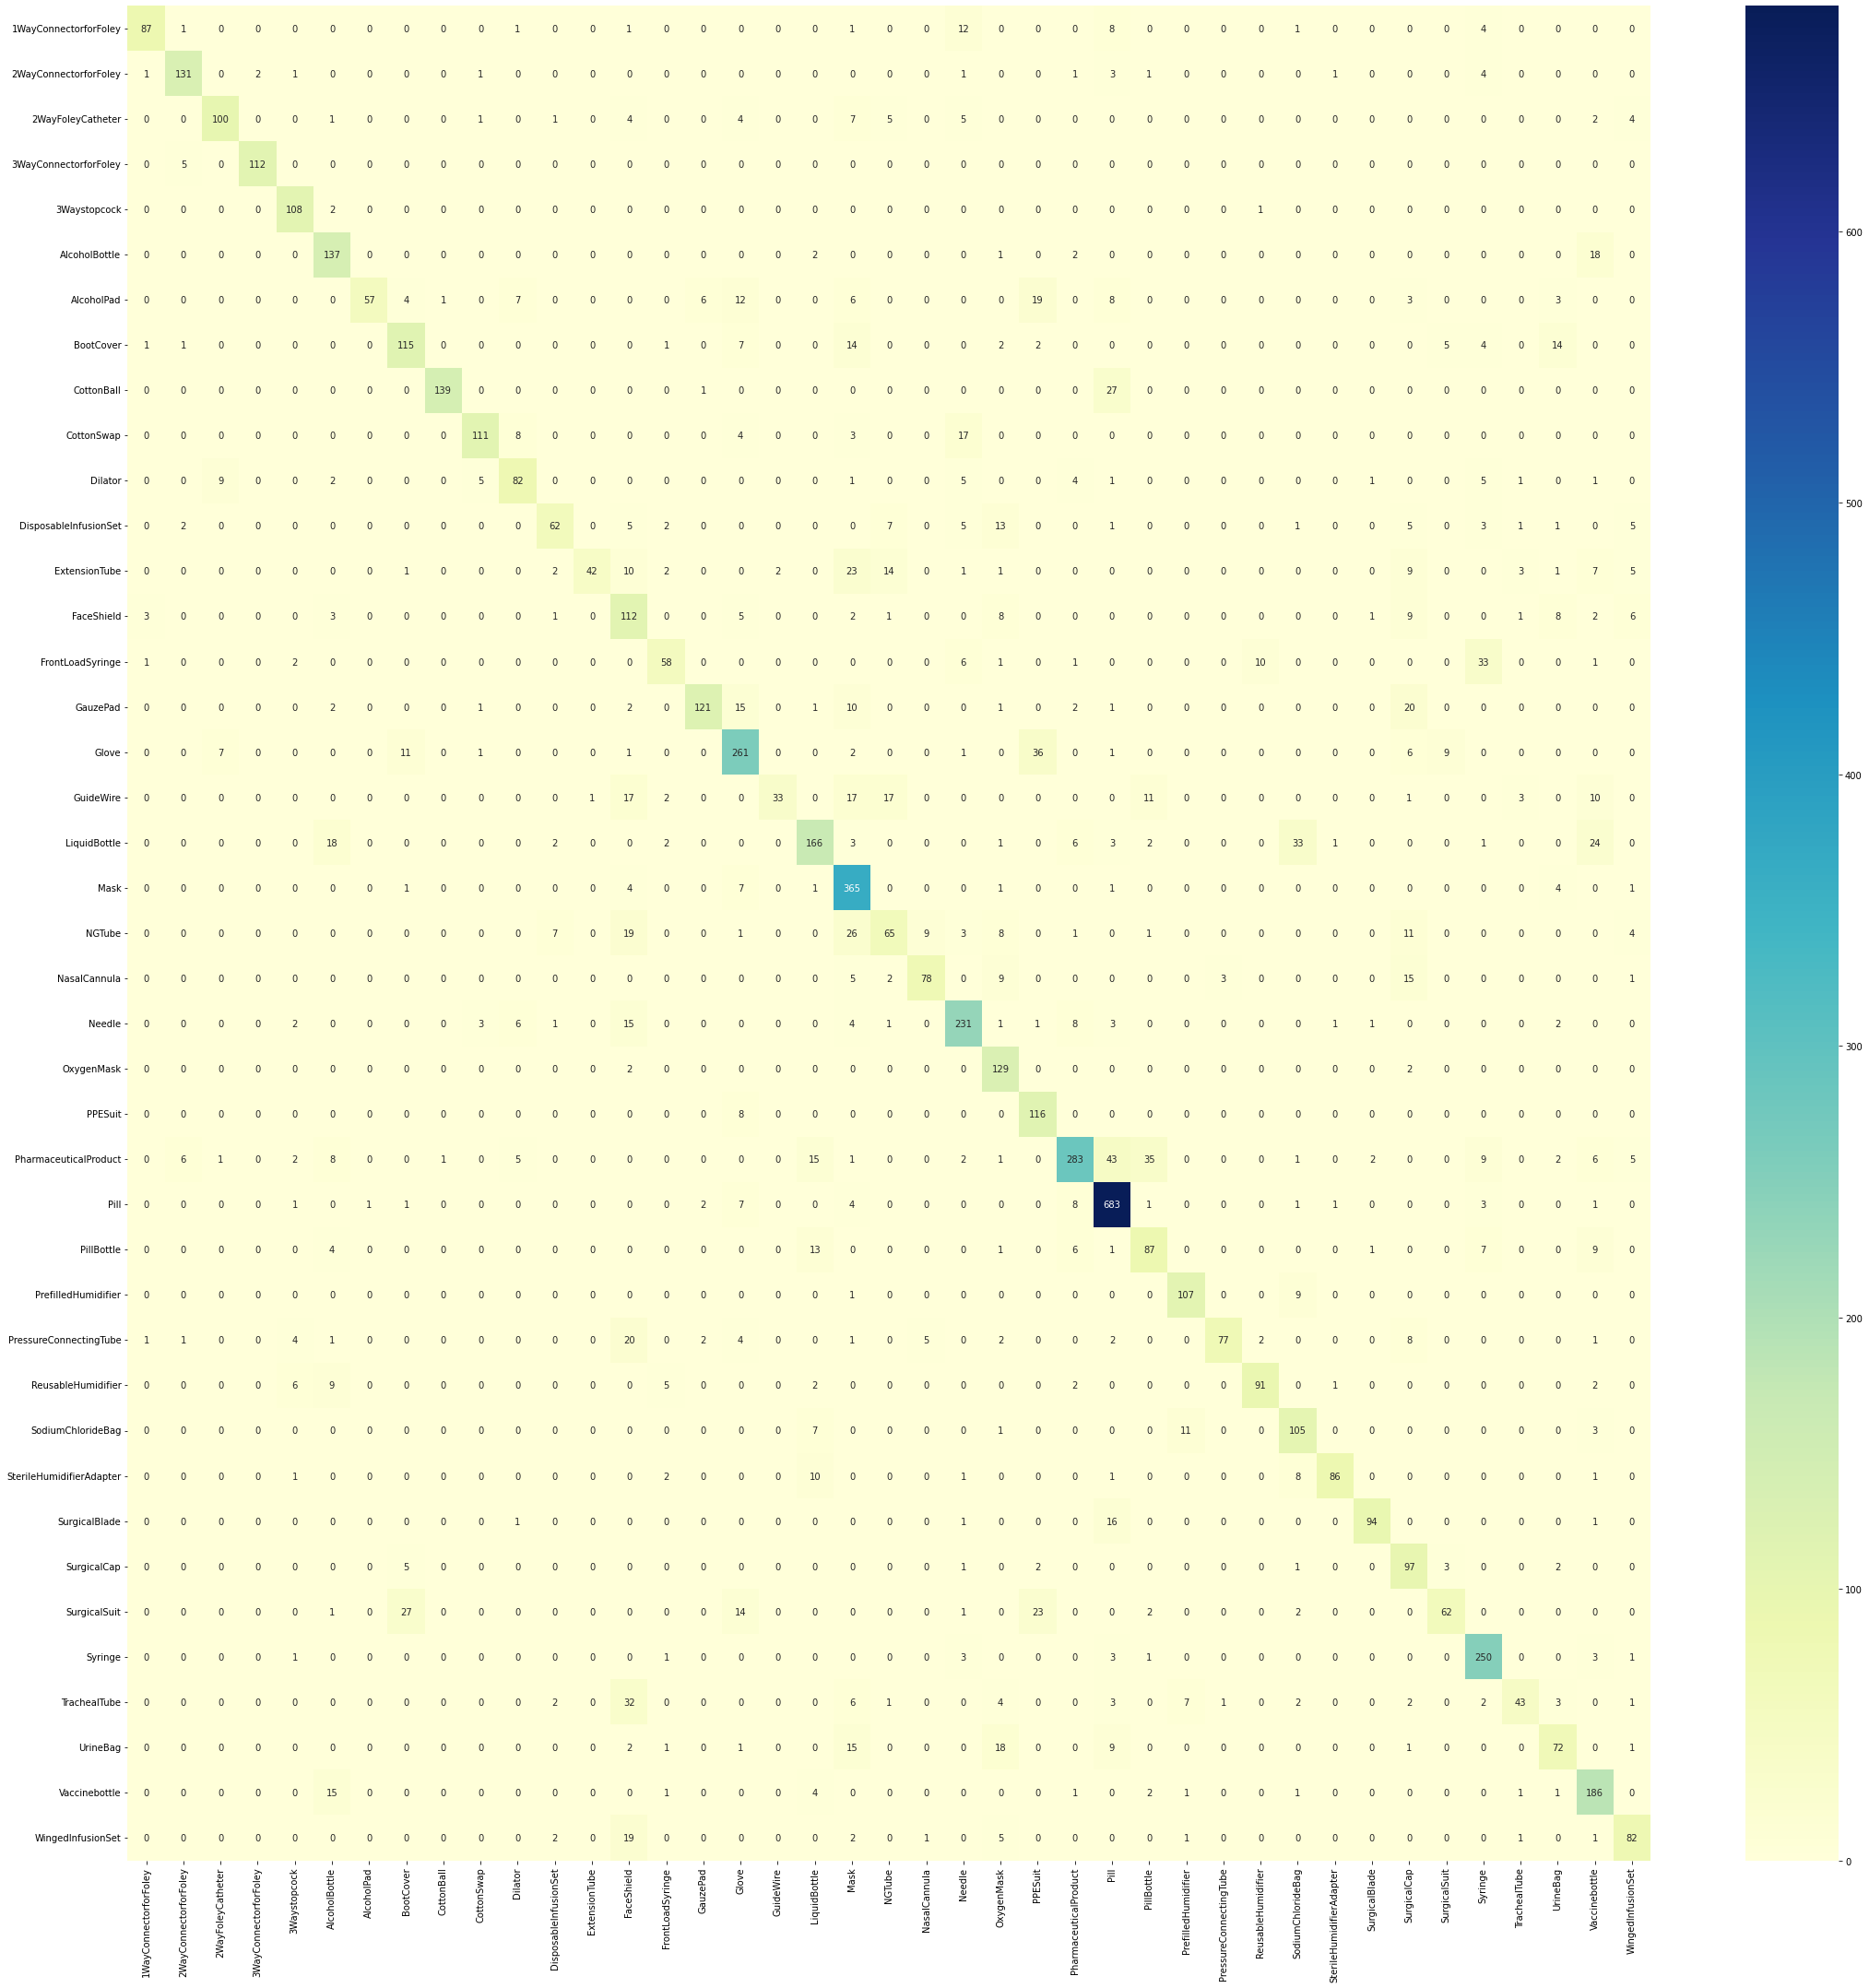

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

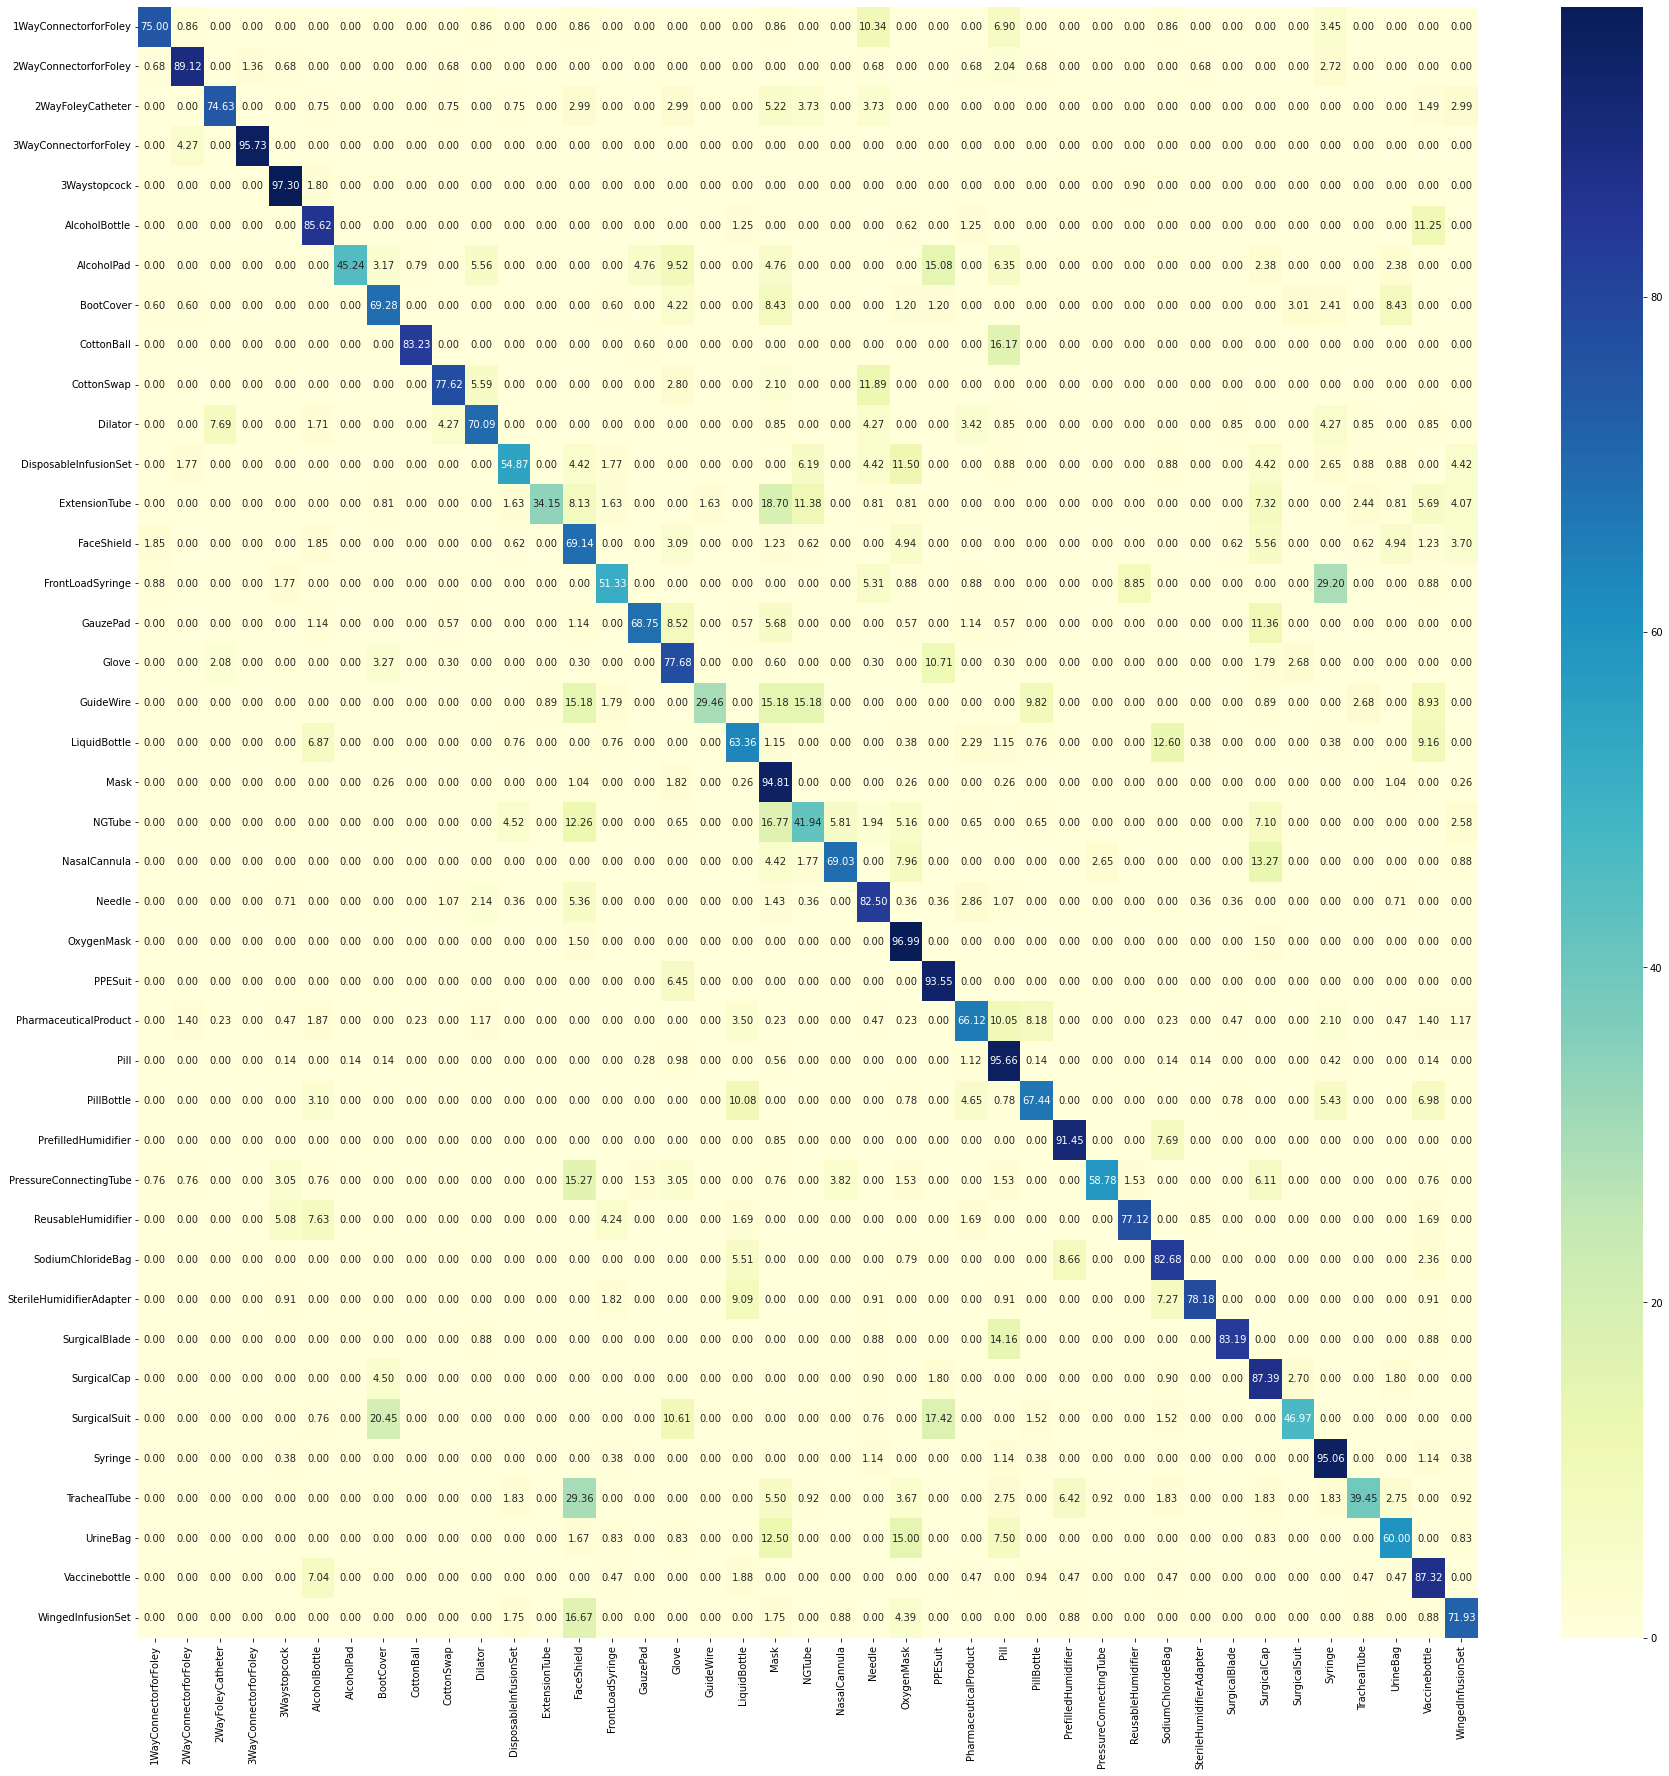

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")